# Algorithmic Motion Planning HW1 - Problem 7a

## Questions
- Can move diagonally?  
    - Why YES might be easier
        - If M-line relative heading is 45°, can move diagonally as opposed to choosing between up and down
    - Why NO might be easier
        - Heading determined by current_pos - prev_pos
        - Based on current heading, LEFT heading = current_heading + 90°

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
%run utils.py
%run bugs.py

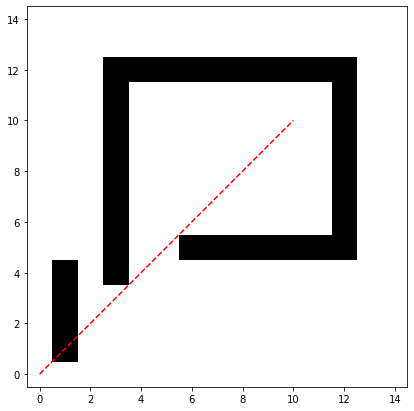

In [18]:
WO1 = [(1,1),(2,1),(2,5),(1,5)]
WO2 = [(3,4),(4,4),(4,12),(3,12)]
WO3 = [(3,12),(12,12),(12,13),(3,13)]
WO4 = [(12,5),(13,5),(13,13,),(12,13)]
WO5 = [(6,5),(12,5),(12,6),(6,6)]
qstart = (0,0)
qgoal = (10,10)

obstacles = [WO1, WO2, WO3, WO4, WO5]

W = np.zeros((15,15))

for obs in obstacles:
    xs = sorted(list(set([coord[0] for coord in obs])))
    ys = sorted(list(set([coord[1] for coord in obs])))
    
    assert (len(xs),len(ys)) == (2,2)
    
    W[xs[0]:xs[1],ys[0]:ys[1]] = 1

fig = plt.figure(figsize=(12,7))
plt.imshow(W.T,cmap='gray_r', origin='lower')
plt.plot([0,10],[0,10],'r--')

In [3]:
pos = np.array([0,0])
qgoal = np.array([10,10])
move_history = pos.copy().reshape(1,-1)

while True:
    # Begin MTG Behavior
    while (pos != qgoal).any():
        move = MTG_move(pos, qgoal)
        if isMoveValid(pos, move, W):
            pos += move
            move_history = add_pos(move_history, pos)
        else:
            break
        
    if (pos == qgoal).all():
        logging.info("Goal Reached")
        break
    
    # Begin Boundary Following Behavior
    logging.debug(f"BEGIN BOUNDARY FOLLOWING -- POS : {pos}\n")
    BF_history = pos.copy().reshape(1,-1)
    BF_distances = np.array([distance(pos, qgoal)])
    pos += first_contact_move(pos, qgoal, W)
    move_history = add_pos(move_history, pos)
    BF_history = add_pos(BF_history, pos)
    BF_distances = np.append(BF_distances,distance(pos, qgoal))
    
    while (pos != BF_history[0]).any() and (pos != qgoal).any():
        move = BF_move(pos, BF_history, qgoal, W)
        pos += move
        move_history = add_pos(move_history, pos)
        BF_history = add_pos(BF_history,pos)
        BF_distances = np.append(BF_distances,distance(pos, qgoal))
    logging.debug("END BOUNDARY FOLLOWING\n")
    if (pos==qgoal).all():
        logging.info("Goal Reached")
        break
    
    logging.debug("BEGIN QL PATH\n")
    index, qL = find_ql(BF_history, BF_distances, hist_loc=True)
    logging.debug(f"QL = {qL}")
    ql_path = shortest_path_to_ql(BF_history, BF_distances)
    move_history = np.vstack([move_history,ql_path])
    pos = move_history.copy()[-1]
    logging.debug(f"END QL PATH -- POS : {pos}\n\n")

INFO:root:Goal Reached


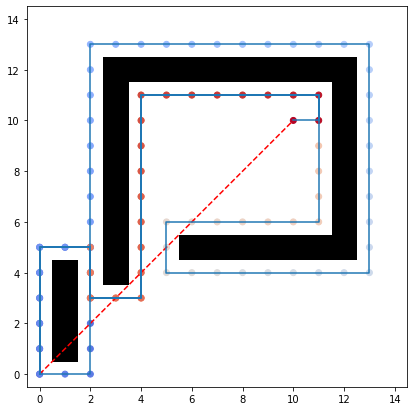

In [4]:
fig = plt.figure(figsize=(12,7))
plt.imshow(W.T,cmap='gray_r', origin='lower')
plt.plot([0,10],[0,10],'r--')
plt.plot(np.array(move_history)[:,0],np.array(move_history)[:,1])
rgbs = plt.cm.get_cmap('coolwarm')(np.linspace(0, 1, move_history.shape[0]))
plt.scatter(np.array(move_history)[:,0],np.array(move_history)[:,1], c=rgbs)

# Bug 2

In [59]:
qstart = np.array([0,0])
pos = qstart.copy()
qgoal = np.array([10,10])
move_history = pos.copy().reshape(1,-1)
m_line_coords = get_m_coords(qstart, qgoal)

while True:
    while (pos != qgoal).any():
        move = MTG_move(pos, qgoal)
        if isMoveValid(pos, move, W):
            pos += move
            move_history = add_pos(move_history, pos)
        else:
            break
            
    if (pos == qgoal).all():
        logging.info("Goal Reached")
        break
    
    # Begin Boundary Following Behavior
    BF_history = pos.copy().reshape(1,-1)
    d_h = distance(pos, qgoal) # hit distance
    logging.debug(f"BEGIN BOUNDARY FOLLOWING -- POS : {pos}\n")
    pos += first_contact_move(pos, qgoal, W)
    move_history = add_pos(move_history, pos)
    BF_history = add_pos(BF_history, pos)
    
    while (pos != qgoal).any():
        if list(pos) in list(map(list,m_line_coords)):
            if distance(pos, qgoal) < d_h:
                break
        
        move = BF_move(pos, BF_history, qgoal, W)
        pos += move
        move_history = add_pos(move_history, pos)
        BF_history = add_pos(BF_history,pos)
        

INFO:root:Goal Reached


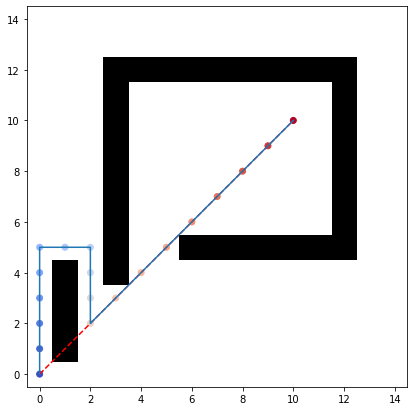

In [60]:
fig = plt.figure(figsize=(12,7))
plt.imshow(W.T,cmap='gray_r', origin='lower')
plt.plot([0,10],[0,10],'r--')
plt.plot(np.array(move_history)[:,0],np.array(move_history)[:,1])
rgbs = plt.cm.get_cmap('coolwarm')(np.linspace(0, 1, move_history.shape[0]))
plt.scatter(np.array(move_history)[:,0],np.array(move_history)[:,1], c=rgbs)

In [53]:
m_line_coords

array([[ 0,  0],
       [ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6,  6],
       [ 7,  7],
       [ 8,  8],
       [ 9,  9],
       [10, 10]])

# Show Colormap

In [71]:
%run utils.py

In [72]:
path = BUG1(np.array(qstart),np.array(qgoal),W)

INFO:root:Goal Reached


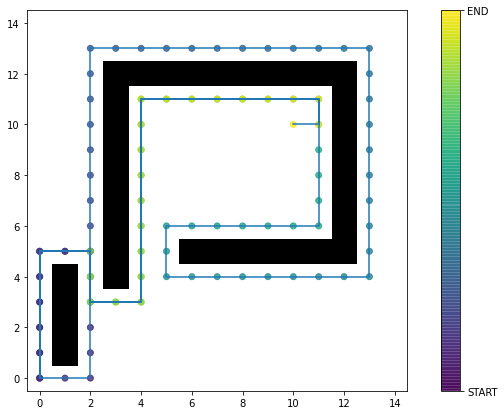

In [73]:
fig, ax = plot_path(path,W)
# ax2 = fig.add_axes([0.25,0.75,0.5,0.5])
# gradient = np.linspace(0,1,256)
# gradient = np.vstack([gradient, gradient])
# ax2.imshow(gradient, cmap='viridis', aspect=1/15, extent=[0,1,0,1])
# ax2.set_yticks([])
# ax2.set_xticks([0,1])
# ax2.set_xticklabels(['START', 'END'])

([<matplotlib.axis.XTick at 0x11a8f3f10>,
 [Text(0, 0, 'START'), Text(0, 0, 'END')])

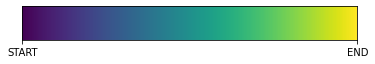

In [15]:
gradient = np.linspace(0,1,256)
gradient = np.vstack([gradient, gradient])
plt.imshow(gradient.reshape(2,-1), cmap='viridis', aspect=1/10, extent=[0,1,0,1])
plt.yticks([])
plt.xticks([0,1],['START', 'END'])

# Bug Algorithms

## Bug 1

In [8]:
def MTG_move_decision(pos,qgoal):
    '''
    Motion-to-Goal move decision
    Make movement decisions amenable to discrete state/action space
    
    INPUT:
        pos (ndarray)[2]: (x,y) Current grid position
        qgoal (ndarray)[2]: (x,y) Goal position
    
    OUTPUT:
        move (ndarray)[2]: array to increment current position
    '''
    if isinstance(pos,np.ndarray):
        rel_dist = np.array(qgoal)-pos
    else:
        rel_dist = list(map(lambda goal,pos: goal-pos,qgoal,pos))
    
    theta = np.arctan2(rel_dist[1],rel_dist[0])
    move = round(np.cos(theta)), round(np.sin(theta))
    
    return np.array(move)

        
def BF_move_decision(BF_hist, pos, qgoal, W, first_contact=False):
    BF_hist = BF_hist.copy()
    if first_contact:
        m = MTG_move_decision(pos,qgoal)
        assert W[tuple(pos+m)] # Ensure that next MTG move is blocked
        heading = np.arctan2(m[1],m[0]) # DOUBLE CHECK ORDER IS CORRECT

        if m.all(): # If heading diagonal, make first search heading closest 90° i.e. current_heading + 45°
            heading += np.deg2rad(45)

        for a in np.deg2rad(np.arange(0,360,90)): # Search in increments of 90° until empty space is found
            test_move = np.round(np.array([np.cos(heading+a), np.sin(heading+a)])).astype(int)
            if not W[tuple(pos+test_move)]: # Check if next CCW position is empty
                return test_move
            
        print("No Valid Move")
        return None
    else:
        prev_pos = BF_hist[-2]
        diff = pos - prev_pos
#         logging.debug("Diff: " + str(diff))
        heading = np.arctan2(diff[1],diff[0])
#         logging.debug("Heading: " + str(np.rad2deg(heading)))
        
        for a in np.arange(heading-np.deg2rad(90),heading+np.deg2rad(90),np.deg2rad(90)):
            test_move = np.round(np.array([np.cos(a),np.sin(a)])).astype(int)
            if not W[tuple(pos+test_move)]:
                return test_move
        
        print("No Valid Move")
        return None

def return_to_qL(BF_hist, BF_distances):
    BF_hist = BF_hist.copy()
    BF_distances = BF_distances.copy()
    qLi_index = np.argmin(BF_distances)
    qLi = BF_hist[qLi_index]
    
    d1 = qLi_index+1
    d2 = len(BF_hist) - qLi_index
    
    if d2 < d1:
        path = BF_hist[qLi_index:][::-1]
    else:
        path = BF_hist[:qLi_index]
    print(path)
    return path

In [9]:
path

NameError: name 'path' is not defined

In [128]:
qL = np.array(qstart)
pos = np.array(qstart)
qgoal = np.array(qgoal)

move_hist = []
timeout = 5
t_start = time.time()
while True:
    
    # Motion to Goal
    logging.debug("\n\nMOTION TO GOAL\n")
    while (pos != qgoal).all():
        move = MTG_move_decision(pos, qgoal)
        if not W[tuple(pos + move)]: # If position is not occupied by obstacle
            pos += move
            move_hist.append(pos.copy())
        else:
            break # Break if next pos is occupied by obstacle -> transition to  boundary following
        
        if time.time()-t_start > timeout:
            break
        logging.debug(pos)
    if (pos == qgoal).all():
        print("Goal Found")
        break
    
    BF_hist = np.array([pos])  # Boundary Following history
    BF_distances = np.array([distance(pos,qgoal)])

    # Boundary Following
    first_contact = True
    logging.debug("\n\nBOUNDARY FOLLOWING\n")
    while (pos != qgoal).any():
        pos += BF_move_decision(BF_hist, pos, qgoal, W, first_contact=first_contact)
        logging.debug(pos)
        BF_hist = np.append(BF_hist,[pos.copy()], axis=0)
        move_hist.append(pos.copy())
        BF_distances = np.append(BF_distances,distance(pos,qgoal))
        first_contact = False
        
        if (pos == BF_hist[0]).all():
            logging.debug("\nEXIT BOUNDARY FOLLOWING")
            logging.debug(f"---> POS: {pos}\n HIST0: {BF_hist[0]}")
            break
        
        if time.time()-t_start > timeout:
            logging.debug("TIMEOUT")
            break
            
    if (pos == qgoal).all():
        print("Goal Found")
        break
    
    logging.debug('BF_HIST \n'+str(BF_hist))
    logging.debug('BF_DISTS \n'+str(BF_distances))
    # Go to qLi
    path = return_to_qL(BF_hist, BF_distances)
    logging.debug(f"PATH: {path}")
    move_hist.extend(list(path))
    pos = path[-1]
    
    if time.time()-t_start > timeout:
        break

DEBUG:root:

MOTION TO GOAL

DEBUG:root:

BOUNDARY FOLLOWING

DEBUG:root:[0 1]
DEBUG:root:[0 2]
DEBUG:root:[0 3]
DEBUG:root:[0 4]
DEBUG:root:[0 5]
DEBUG:root:[1 5]
DEBUG:root:[2 5]
DEBUG:root:[2 4]
DEBUG:root:[2 3]
DEBUG:root:[2 2]
DEBUG:root:[2 1]
DEBUG:root:[2 0]
DEBUG:root:[1 0]
DEBUG:root:[0 0]
DEBUG:root:
EXIT BOUNDARY FOLLOWING
DEBUG:root:---> POS: [0 0]
 HIST0: [0 0]
DEBUG:root:BF_HIST 
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [1 5]
 [2 5]
 [2 4]
 [2 3]
 [2 2]
 [2 1]
 [2 0]
 [1 0]
 [0 0]]
DEBUG:root:BF_DISTS 
[14.14213562 13.45362405 12.80624847 12.20655562 11.66190379 11.18033989
 10.29563014  9.43398113 10.         10.63014581 11.3137085  12.04159458
 12.80624847 13.45362405 14.14213562]
DEBUG:root:PATH: [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [1 5]]
DEBUG:root:

MOTION TO GOAL

DEBUG:root:[2 5]
DEBUG:root:

BOUNDARY FOLLOWING

DEBUG:root:[2 6]
DEBUG:root:[2 7]
DEBUG:root:[2 8]
DEBUG:root:[2 9]
DEBUG:root:[ 2 10]
DEBUG:root:[ 2 11]
DEBUG:root:[ 2 12]
DEBUG:root:[ 2 13]
DE

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [1 5]]
No Valid Move


TypeError: ufunc 'add' output (typecode 'O') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind''

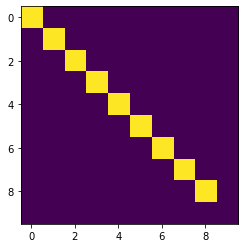

In [84]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep

n = 10
a = np.zeros((n, n))
plt.figure()

for i in range(n):
    plt.imshow(a)
    plt.show()
    a[i, i] = 1
    sleep(0.1)
    clear_output(wait=True)

In [85]:
from celluloid import Camera

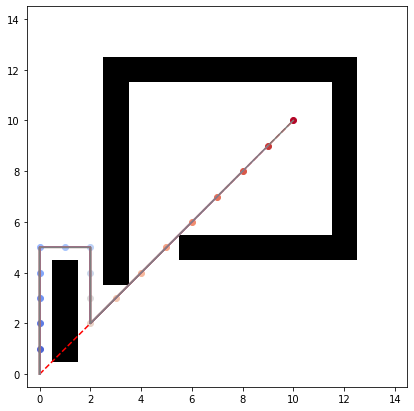

In [87]:
fig = plt.figure(figsize=(12,7))
camera = Camera(fig)
plt.imshow(W.T,cmap='gray_r', origin='lower')
rgbs = plt.cm.get_cmap('coolwarm')(np.linspace(0, 1, move_history.shape[0]))
plt.plot([0,10],[0,10],'r--')
for i in range(1,move_history.shape[0]):
    plt.plot(np.array(move_history)[:,0][:i+1],np.array(move_history)[:,1][:i+1])
    plt.scatter(np.array(move_history)[:,0][i],np.array(move_history)[:,1][i], color=rgbs[i])
    camera.snap()

In [88]:
animation = camera.animate()

In [89]:
from IPython.display import HTML

In [90]:
HTML(animation.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 864x504 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/c0/25_cwvs977j_tpk6hd3zzhjh0000gn/T/tmp3yfnagxq/temp.m4v
dyld: Library not loaded: @rpath/libopenh264.5.dylib
  Referenced from: /Users/tyler/opt/anaconda3/lib/libavcodec.58.dylib
  Reason: image not found



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x504', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/c0/25_cwvs977j_tpk6hd3zzhjh0000gn/T/tmp3yfnagxq/temp.m4v']' died with <Signals.SIGABRT: 6>.